# 2 - Rede neural de uma camada

Nosso objetivo é usar redes neurais para gerar algo que se parece com português. Mais especificamente, algo que se pareça com um português específico --- aquele usado por Machado de Assis.

O código desse notebook é adaptado do repositório `nn-zero-to-hero`, de Andrej Karpathy. Os notebooks correspondentes (em inglês) podem ser encontradas na seguinte URL: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/.

-------------------------------

## 2.1 Criando datasets de treino, validação e teste

Como antes, vamos criar os dicionários que relacionam os caracteres e seus respectivos valores inteiros:

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("../data/gpt/processed/machado-all.txt", "r") as f:
    text = f.read()

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: entra string, saem inteiros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: entram inteiros, sai uma string

In [4]:
len(text)

14460835

In [5]:
data = text
print(data[1079:1172])

deve ser o contraste do roastbeef britânico, com que se alimenta a liberdade do reino unido. 


Como no caso dos trigramas de antes, vamos usar um contexto com 3 caracteres (mas o código abaixo funciona para tamanhos arbitrários).

In [6]:
block_size = 3 # tamanho do contexto
X, Y = [], []
context = [0] * block_size
for i, ch in enumerate(data):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    if i < 5:
        print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

    ---> c
  c ---> o
 co ---> n
con ---> t
ont ---> o


Como exatamente está estruturado esse dataset? Temos uma sequência de inteiros correspondendo aos três primeiros caracteres, e queremos prever o quarto. Vamos usar a primeira palavra como um exemplo.

In [7]:
first_word = "   " + text.split(" ")[0]
print("\t".join(first_word))
print("\t".join([str(stoi[c]) for c in first_word]))

 	 	 	c	o	n	t	o	,
0	0	0	7	19	18	24	19	1


In [8]:
print(X)
print(Y)

tensor([[ 0,  0,  0],
        [ 0,  0,  7],
        [ 0,  7, 19],
        ...,
        [16,  9, 23],
        [ 9, 23,  5],
        [23,  5, 23]])
tensor([ 7, 19, 18,  ...,  5, 23,  3])


Com uma rede neural mais complicada, é fácil overfit ao nosso conjunto de treino. Para monitorar essa possibilidade, vamos dividir os dados em treino, validação e teste.

In [9]:
block_size = 3

def build_dataset(data):  
    X, Y = [], []
    context = [0] * block_size
    for ch in data:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8*len(data))
n2 = int(0.9*len(data))

Xtr, Ytr = build_dataset(data[:n1])
Xdev, Ydev = build_dataset(data[n1:n2])
Xte, Yte = build_dataset(data[n2:])

In [10]:
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape) 

torch.Size([11568668, 3]) torch.Size([11568668])
torch.Size([1446083, 3]) torch.Size([1446083])
torch.Size([1446084, 3]) torch.Size([1446084])


## 2.2 Embeddings

Com o dataset pronto, podemos começar a considerar o modelo de rede neural. A ideia é primeiro criar um "embedding" que seja melhor do que one-hot encoding. De fato, o one-hot encoding usa um espaço de dimensão 42 para cada caractere, mas a gente espera que eles possam ser bem representados em dimensões menores. Vamos considerar em duas dimensões, por simplicidade.

In [11]:
one_hot = torch.nn.functional.one_hot(Xtr, num_classes=vocab_size).float()
one_hot.shape

torch.Size([11568668, 3, 42])

In [12]:
one_hot[0, 0, :]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])

In [13]:
# O acima equivale à entrada (0, 0) do treino ser 0, isto é, caractere ' '
itos[Xtr[0, 0].item()]

' '

Do nosso ponto de vista, um embedding é simplesmente uma matriz que recebe os caracteres em `X` e os projeta em um espaço de dimensão dois. Vamos inicializá-lo de maneira aleatória, mas esse embedding será aprendido em breve.

In [14]:
torch.manual_seed(0)
C = torch.randn((vocab_size, 2))

In [15]:
emb = one_hot @ C
emb.shape

torch.Size([11568668, 3, 2])

In [16]:
emb[0, 0, :]

tensor([-1.1258, -1.1524])

Ou seja, o embedding transformou cada um dos três inteiros representando os caracteres que antecedem a nossa previsão em um ponto de $\mathbb{R}^2$. Por isso, para cada ponto de treino (total de 11615619), e para cada uma das três palavras nesse ponto de treino (total de 3) temos um elemento de $\mathbb{R}^2$. Antes, com one-hot, tínhamos um elemento em $\mathbb{R}^{42}$.

Existe uma maneira um pouco mais otimizada de fazer a operação acima, que não nos obriga a criar o tensor `one_hot`. Note que multiplicar `C` por um vetor de zeros e uns equivale a escolher uma linha de `C`. Podemos fazer isso diretamente:

In [17]:
emb = C[Xtr]
emb.shape

torch.Size([11568668, 3, 2])

In [18]:
emb[0, 0, :]

tensor([-1.1258, -1.1524])

Então agora conseguimos levar os caracteres em pontos de $\mathbb{R}^2$. A partir daqui, podemos juntar os três caracteres de cada instância num único vetor de seis elementos:

In [19]:
print(emb[2, 0, :])
print(emb[2, 1, :])
print(emb[2, 2, :])
print(emb.view(-1, 6)[2])

tensor([-1.1258, -1.1524])
tensor([ 1.1168, -0.2473])
tensor([0.6408, 0.4412])
tensor([-1.1258, -1.1524,  1.1168, -0.2473,  0.6408,  0.4412])


## 2.3 Função-perda

Como medimos o sucesso de uma previsão? Como já vimos antes, uma perda razoável nesse contexto é a entropia cruzada, que já derivamos como a log-verossimilhança de uma distribuição Multinomial.

Suponha que o i-ésimo caractere a ser previsto seja descrito através de one-hot encoding na dimensão do nosso vocabulário ($K=42$), isto é, $y_i = (y_i^{[1]}, \ldots, y_i^{[K]})=(0, \ldots, 0, 1, 0, \ldots, 0)$, e que as previsões da rede sejam $\hat{p}_i = (\hat{p}_i^{[1]}, \ldots, \hat{p}_i^{[K]})$, aonde $\sum_{k=1}^K \hat{p}_i^{[k]} =1$. Então, a perda é dada por
$$
L(\hat{p}, y) = - \frac{1}{n}\sum_{i=1}^n\left(\sum_{k=1}^K y_i^{[k]} \log \hat{p}_i^{[k]}\right) = - \frac{1}{n}\sum_{i=1}^n \log \hat{p}_i^{[k^*]},
$$
onde acima $k^*$ denota o caractere que de fato apareceu na $i$-ésima posição.

Qual é a ideia? Se acertamos $\hat{p}_i^{[k]}=1$ no caractere certo (quando $y_i^{[k]}=1$; ou seja, $\hat{p}_i^{[k^*]}=1$), então a contribuição para a perda na instância $i$ é $0$. Mas na medida em que prevemos $\hat{p}_i^{[k^*]} < 1$, pagamos um preço quanto menor for $\hat{p}_i^{[k^*]}$.

Agora, vamos criar nossa camada escondida com uma ativação tanh, e depois converter os pesos finais em probabilidades via uma softmax:

In [20]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([11568668, 100])

In [21]:
W2 = torch.randn((100, vocab_size))
b2 = torch.randn(vocab_size)
logits = h @ W2 + b2
logits.shape

torch.Size([11568668, 42])

In [22]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([11568668, 42])

In [23]:
loss = -prob[torch.arange(Ytr.shape[0]), Ytr].log().mean()
loss.item()

19.811634063720703

Ok, não parece ser uma perda boa! Se fizéssemos uma previsão uniforme de qual é o caractere seguinte, teríamos uma perda muito mais razoável, pois cada caractere visto seria previsto uniformemente com probabilidade 1/(tamanho do vocabulário), de modo que a perda média seria:

In [24]:
-torch.tensor(1/len(itos)).log().item()

3.7376697063446045

## 2.4 Treinando a rede neural

O problema, é claro, é que ainda não treinamos nossa rede para aprender a prever caracteres direito. Vamos resolver isso agora. Em particular, vamos usar um embedding de dimensão 10 ao invés de 2.

In [25]:
vocab_size = len(itos)  # número de caracteres: 42
n_embd = 10  # dimensionalidade do vetor de embedding
n_hidden = 100  # número de neurônios na camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

Podemos facilmente calcular o número total de parâmetros que temos:

In [26]:
(vocab_size * n_embd) + (n_embd * block_size * n_hidden) + (n_hidden) + (n_hidden * vocab_size) + (vocab_size)

7762

Alternativamente, podemos usar o seguinte código mais geral:

In [27]:
sum(p.nelement() for p in parameters)

7762

Precisamos avisar ao PyTorch de que esses parâmetros têm gradientes, e que eles precisam ser calculados durante o treino.

In [28]:
for p in parameters:
    p.requires_grad = True

Pronto: podemos usar nosso código de treino. Como temos uma quantidade enorme de dados de treino, não faz sentido calcular o gradiente usando todos os pontos --- tomaria tempo demais. Ao invés, escolhemos alguns pontos aleatoriamente e o gradiente médio deles é que será usado para escolher a direção de descida. Aqui, usamos um tamanho de batch de 32.

In [29]:
stepi = []
lossi = []

max_steps = 100000
batch_size = 32

for i in range(max_steps):
  
    # batch: 32 números aleatórios entre 0 e n_tr = 11615619
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed os caracateres num vetor (batch_size, block_size, n_embd) = (32, 3, 10)
    embcat = emb.view(-1, n_embd * block_size)  # concatenação das últimas duas dimensões
    hpreact = embcat @ W1 + b1  # transformação afim
    h = torch.tanh(hpreact) # camada escondida: (32, 200)
    logits = h @ W2 + b2 # output: (32, 44)
    loss = F.cross_entropy(logits, Yb)  # função-perda

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 80000 else 0.01  # decaimento da learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())

      0/ 100000: 21.1271
  10000/ 100000: 2.0981
  20000/ 100000: 2.1155
  30000/ 100000: 2.3727
  40000/ 100000: 1.8811
  50000/ 100000: 1.6864
  60000/ 100000: 1.9813
  70000/ 100000: 2.1054
  80000/ 100000: 1.6578
  90000/ 100000: 1.6502


Podemos plotar o gráfico da perda ao longo do tempo. Mas note que a perda aqui está em escala logarítmica (`loss.log10()`) e que estamos plotando a perda em cada batch, que é aleatório, então esperaríamos algum ruído por conta dos 32 exemplos escolhidos em cada batch.

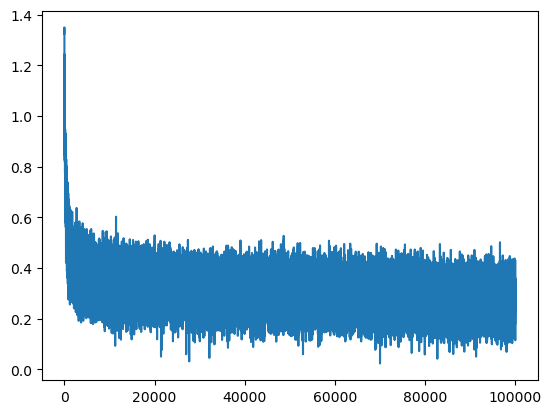

In [30]:
plt.plot(stepi, lossi)

Para retirar o ruído devido ao minibatch, podemos olhar para a média ao longo de cada cem passos:

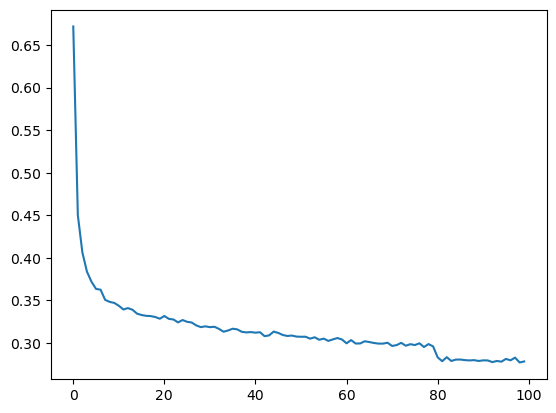

In [31]:
plt.plot(torch.tensor(lossi).view(100, 1000).mean(1))

Além disso, podemos olhar para a perda no conjunto de treino todo:

In [32]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9151, grad_fn=<NllLossBackward0>)

É uma perda de treino muito melhor do que antes! Mas será que isso se deve a um possível overfit? Para isso, vamos olhar para a perda de validação:

In [33]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.8830, grad_fn=<NllLossBackward0>)

Vamos interpretar esse valor: vimos que se escolhéssemos aleatoriamente um dos 42 caracteres, a perda média seria $-\log(1/42) \approx 3.7377$, ou seja estávamos escolhendo dentre $e^{3.7377} \approx 42$ caracteres. Agora, a perda caiu para $1.8830$, então é como se, cada novo caractere fosse uniformemente escolhido dentre $e^{1.8830} \approx 6.5$ caracteres! Parece uma boa redução.

Finalmente, vamos ver se na prática estamos encontrando gerando texto mais razoável.

In [34]:
g = torch.Generator().manual_seed(10)
out = []
context = [0] * block_size
for i in range(300):
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    
print(''.join(itos[i] for i in out))

équeste sas palta. vico, e eceu que irado crite ou cetélizimpet, e, anos olhos do dos car, que lados, que bera de pancasa, esivarque não as e que empras na mino cordade, ré caso nem deira imporou sevam goposta. ques, dem-se tlasa de es, cunos que a todo a bando cronsa-se em fou volto sonchos eu a qu


Não parece um avanço óbvio em relação aos trigramas. Mas a vantagem dessa approach é que temos alguns ases na manga para melhorá-lo substancialmente.